# Autoencoder

This is a 4 layers Autoencoder(2 encoder + 2 decoder) for performing dimensionality reduction on the GEFCOM-2014 load forecasting data

In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
import os
import pickle
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
from matplotlib.pyplot import figure

# Data Preprocessing & Staging

In [2]:
def get_data(file_name):
    data = pd.read_csv(file_name)
    data = data.to_numpy()
    for i in range(data.shape[0]):
        data[i, 1] = datetime.strptime(data[i, 1], "%m%d%Y %H:%M").date()
    power = data[:, 2].astype(np.float64)
    indexes = np.isnan(power)
    cleaned_data = data[~indexes, :]
    return cleaned_data

def embed_data(lead_time, embed_dim, from_date, to_date, data, t_idx, dt_idx):
    start = np.where(data[:, dt_idx] == from_date)[0][0]
    end = np.where(data[:, dt_idx] == to_date)[0][-1]
    X, y = [], []
    for idx in range(start, end+1):
        xx = data[idx-(embed_dim+lead_time-1):idx-lead_time+1, 3:]
        yy = data[idx, 2]
        X.append(xx)
        y.append(yy)
    return np.array(X), np.array(y)

def get_data_between_time(data, from_date, to_date, dt_idx):
    start = np.where(data[:, dt_idx] == from_date)[0][0]
    end = np.where(data[:, dt_idx] == to_date)[0][-1]
    return data[start:(end+1), :]


def normalize(data):
    for i in range(2, data.shape[1]):
        data[:, i] = (data[:, i] - np.mean(data[:, i]))/np.std(data[:, i])
    return data

In [49]:
from sklearn.decomposition import PCA
data = get_data('../Dataa/Task 1/L1-train.csv')
data = normalize(data)
dataactual=data[:,3:]

In [50]:
print(dataactual.shape)

(50376, 25)


In [51]:
print(dataactual)

[[-1.0682467564243037 -0.9319257986324055 -0.9618264508933926 ...
  -0.8900772206990581 -0.8460325215149895 -0.9108400548369758]
 [-1.1831429734183943 -0.9319257986324055 -1.0832982359183199 ...
  -0.8900772206990581 -0.8460325215149895 -0.9108400548369758]
 [-1.2405910819154395 -0.9319257986324055 -1.1440341284307833 ...
  -0.9475564729698909 -0.9038780725289747 -1.0265962403074795]
 ...
 [0.7126446069841011 0.47318180138723054 0.3136272918683433 ...
  0.48942483380092805 0.4844151518066707 0.5361122635443207]
 [0.6551964984870559 0.47318180138723054 0.3136272918683433 ...
  0.5469040860717608 0.6001062538346411 0.5361122635443207]
 [0.5403002814929652 0.47318180138723054 0.3743631843808069 ...
  0.5469040860717608 0.36872404977870027 0.4782341708090689]]


In [55]:
pcaa = PCA(n_components=10)
principalComponents = pcaa.fit_transform(dataactual)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['1','2','3','4','5','6','7','8','9','10'])
pdf=principalDf.to_numpy()
result = np.hstack(( np.atleast_2d(data[:,2]).T,pdf)) 
result = np.hstack(( np.atleast_2d(data[:,1]).T,result)) 
result = np.hstack((np.atleast_2d(data[:,0]).T,result)) 


In [56]:
print(principalDf.index[0])
print(principalDf.index[-1])
principalDf.head()

0
50375


,1,2,3,4,5,6,7,8,9,10
0,4.566602,-0.093160,-0.343859,0.067665,0.029243,-0.442420,0.018236,-0.174663,0.151819,-0.126880
1,4.628722,0.004835,-0.272167,-0.098046,-0.011761,-0.315610,0.197051,-0.174687,0.036394,-0.023859
2,4.910206,-0.049068,-0.450476,-0.149179,0.039220,-0.252723,0.211010,-0.124321,-0.062594,0.070434
3,4.861920,-0.102269,-0.307686,-0.155568,-0.060778,-0.309647,0.221295,-0.045340,0.180990,0.097413
4,4.996918,-0.095231,-0.381688,-0.262827,0.008140,-0.278533,0.167702,-0.081630,0.199273,0.091227


In [57]:
print(result.shape)
print(result)


(50376, 13)
[[1 datetime.date(2005, 1, 1) -0.4252401471841657 ...
  -0.17466340257377716 0.15181939416924545 -0.12688010056566054]
 [1 datetime.date(2005, 1, 1) -0.5109688790207725 ...
  -0.17468743781775703 0.03639439868870091 -0.023858938180635437]
 [1 datetime.date(2005, 1, 1) -0.6138433572247005 ...
  -0.12432091681162749 -0.06259422904717793 0.07043385557728205]
 ...
 [1 datetime.date(2010, 9, 30) 0.2177253415903853 ...
  -0.010984092620579573 -0.16075311855581184 0.1178053653482231]
 [1 datetime.date(2010, 9, 30) -0.03946085391943498 ...
  0.08605060434295038 -0.23467152825507911 0.04040907201163119]
 [1 datetime.date(2010, 10, 1) -0.33093854216389845 ...
  -0.06301255846719225 -0.20934241515206659 -0.027374703059433236]]


In [74]:
embedded_data_pca, target_pca = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=2, year=2006, day=1),
    to_date = date(month=4, year=2006, day=30),
    data = result,
    t_idx = 2,
    dt_idx = 1
)

In [79]:
embedded_data_original, target_original = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=2, year=2006, day=1),
    to_date = date(month=4, year=2006, day=30),
    data = data,
    t_idx = 2,
    dt_idx = 1
)

In [69]:
# torch.save(autoencoder.state_dict(), './data/autoencoder_params')

# new_autoencoder = Autoencoder(
#     input_size = 25,
#     down_size = 15
# )

# new_autoencoder.load_state_dict(torch.load('./data/autoencoder_params'))

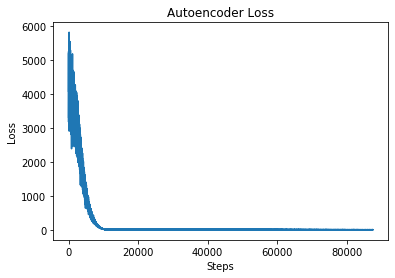

In [68]:
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Autoencoder Loss')
plt.show()

## New Reduced Data

In [4]:
dataTensor = Variable(torch.from_numpy(data[:, 3:].astype(np.float32)))
encoded_data_without_date = autoencoder.forward(dataTensor, decode=False, no_act=True).detach().numpy()
encoded_data = np.concatenate((data[:, :3], encoded_data_without_date), axis=1)
embedded_encoded_data, target = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=1, year=2006, day=1),
    to_date = date(month=3, year=2006, day=31),
    data = encoded_data,
    t_idx = 2,
    dt_idx = 1
)

NameError: name 'autoencoder' is not defined

# LSTM for forecasting

In [174]:
class QuantileRegression(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 10)
        self.fc_out = nn.Linear(10, output_size)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        batch_size = x.size(0)
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(batch_size*self.num_layers, self.hidden_size)
#         print(ula.size(), h_out.size())
#         h_out = h_out.view(-1, self.hidden_size)
        
#         ula = ula.contiguous().view(x.size(0),-1)
        
        fc1 = self.fc(h_out)
        out = self.fc_out(fc1)
        
        return out
    
    def train_model(self, trainX, trainY, lr, epochs, sample_size):
        learning_rate = lr
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        losses = []
        num_epochs = epochs
        
        for epoch in range(num_epochs):  
            indices = torch.randperm(trainX.size()[0])
            trainX, trainY = trainX[indices, :, :], trainY[indices]
            for i in range(0, trainX.size()[0], sample_size):
                xx = trainX[i: i + sample_size, :, :]
                yy = trainY[i: i + sample_size]
                outputs = self.forward(xx)
                outputs = outputs.view(self.num_layers, self.output_size, -1)
                optimizer.zero_grad()
                alpha = 0.1
                # obtain the loss function
                loss = self.quantile_loss(outputs[-1, :, :], yy, alpha)
                losses.append(loss.item())
                loss.backward()

                optimizer.step()
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            
        return losses
    
    def train_sgd(self, trainX, trainY, lr, epochs, sample_size):
        learning_rate = lr
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        losses = []
        num_epochs = epochs
        for epoch in range(num_epochs):
            for xx, yy in zip(trainX, trainY):
                xx = xx.view(1, self.seq_length, self.input_size)
                outputs = self.forward(xx)
                optimizer.zero_grad()

                # obtain the loss function
                loss = self.quantile_loss(outputs, yy, alpha=0.1)
                losses.append(loss)
                loss.backward()

                optimizer.step()
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        return losses
    
    def quantile_loss(self, output, target, alpha = 0.1):
        covered_flag = (output <= target).float()
        uncovered_flag = (output > target).float()
        return torch.mean((target - output)*(alpha)*covered_flag + (output-target)*(1-alpha)*uncovered_flag)

In [175]:
regressor_pca = QuantileRegression(
    input_size = 10,
    hidden_size = 40,
    output_size = 1,
    num_layers = 1,
    seq_length = 12
)

train_x_pca = embedded_data_pca.astype(np.float32)
train_y_pca = target_pca.astype(np.float32)



trainX_pca = Variable(torch.from_numpy(train_x_pca))
trainY_pca = Variable(torch.from_numpy(train_y_pca))

losses_pca = regressor_pca.train_model(
    trainX = trainX_pca,
    trainY = trainY_pca,
    lr = 0.005,
    epochs = 40,
    sample_size = 50
)

Epoch: 0, loss: 0.07024
Epoch: 1, loss: 0.08055
Epoch: 2, loss: 0.08033
Epoch: 3, loss: 0.06548
Epoch: 4, loss: 0.05969
Epoch: 5, loss: 0.04793
Epoch: 6, loss: 0.05669
Epoch: 7, loss: 0.04734
Epoch: 8, loss: 0.04506
Epoch: 9, loss: 0.04397
Epoch: 10, loss: 0.05537
Epoch: 11, loss: 0.04216
Epoch: 12, loss: 0.04154
Epoch: 13, loss: 0.05590
Epoch: 14, loss: 0.04795
Epoch: 15, loss: 0.05201
Epoch: 16, loss: 0.04290
Epoch: 17, loss: 0.02780
Epoch: 18, loss: 0.05297
Epoch: 19, loss: 0.04144
Epoch: 20, loss: 0.03706
Epoch: 21, loss: 0.03277
Epoch: 22, loss: 0.04838
Epoch: 23, loss: 0.03509
Epoch: 24, loss: 0.03992
Epoch: 25, loss: 0.03495
Epoch: 26, loss: 0.04340
Epoch: 27, loss: 0.02282
Epoch: 28, loss: 0.04316
Epoch: 29, loss: 0.03036
Epoch: 30, loss: 0.02681
Epoch: 31, loss: 0.03261
Epoch: 32, loss: 0.02879
Epoch: 33, loss: 0.02570
Epoch: 34, loss: 0.03046
Epoch: 35, loss: 0.02889
Epoch: 36, loss: 0.03090
Epoch: 37, loss: 0.03523
Epoch: 38, loss: 0.03010
Epoch: 39, loss: 0.02723


In [176]:
regressor = QuantileRegression(
    input_size = 25,
    hidden_size = 40,
    output_size = 1,
    num_layers = 1,
    seq_length = 12
)

train_x = embedded_data_original.astype(np.float32)
train_y = target_original.astype(np.float32)



trainX = Variable(torch.from_numpy(train_x))
trainY = Variable(torch.from_numpy(train_y))

losses = regressor.train_model(
    trainX = trainX,
    trainY = trainY,
    lr = 0.005,
    epochs = 40,
    sample_size = 50
)

Epoch: 0, loss: 0.07941
Epoch: 1, loss: 0.07723
Epoch: 2, loss: 0.06447
Epoch: 3, loss: 0.07276
Epoch: 4, loss: 0.06823
Epoch: 5, loss: 0.06510
Epoch: 6, loss: 0.06061
Epoch: 7, loss: 0.05573
Epoch: 8, loss: 0.06115
Epoch: 9, loss: 0.05808
Epoch: 10, loss: 0.06840
Epoch: 11, loss: 0.05669
Epoch: 12, loss: 0.05826
Epoch: 13, loss: 0.05620
Epoch: 14, loss: 0.05622
Epoch: 15, loss: 0.05999
Epoch: 16, loss: 0.05759
Epoch: 17, loss: 0.06912
Epoch: 18, loss: 0.05695
Epoch: 19, loss: 0.05720
Epoch: 20, loss: 0.05469
Epoch: 21, loss: 0.04773
Epoch: 22, loss: 0.04257
Epoch: 23, loss: 0.04181
Epoch: 24, loss: 0.03924
Epoch: 25, loss: 0.05147
Epoch: 26, loss: 0.04301
Epoch: 27, loss: 0.06202
Epoch: 28, loss: 0.04620
Epoch: 29, loss: 0.04648
Epoch: 30, loss: 0.03612
Epoch: 31, loss: 0.04501
Epoch: 32, loss: 0.03789
Epoch: 33, loss: 0.04524
Epoch: 34, loss: 0.03014
Epoch: 35, loss: 0.03917
Epoch: 36, loss: 0.03988
Epoch: 37, loss: 0.03442
Epoch: 38, loss: 0.04488
Epoch: 39, loss: 0.04769


In [177]:
embedded_encoded_datax, targetx = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=5, year=2006, day=1),
    to_date = date(month=5, year=2006, day=31),
    data = result,
    t_idx = 2,
    dt_idx = 1
)

In [178]:
embedded_encoded_data_originalx, target_originalx = embed_data(
    lead_time = 6,
    embed_dim = 12,
    from_date = date(month=5, year=2006, day=1),
    to_date = date(month=5, year=2006, day=31),
    data = data,
    t_idx = 2,
    dt_idx = 1
)

In [179]:
test_x_pca = embedded_encoded_datax.astype(np.float32)
test_y_pca = targetx.astype(np.float32)

In [180]:
test_x = embedded_encoded_data_originalx.astype(np.float32)
test_y = target_originalx.astype(np.float32)

In [181]:
def quantile_loss_numpy(output, target, alpha):
    covered_flag = (output <= target).astype(np.float32)
    uncovered_flag = (output > target).astype(np.float32)
    return np.mean((target - output)*(alpha)*covered_flag + (output-target)*(1-alpha)*uncovered_flag)

In [182]:
def quantile_loss(output, target, alpha = 0.5):
        covered_flag = (output <= target).float()
        uncovered_flag = (output > target).float()
        return torch.mean((target - output)*(alpha)*covered_flag + (output-target)*(1-alpha)*uncovered_flag)

In [183]:
regressor_pca.eval()
testX_pca = Variable(torch.from_numpy(test_x_pca))
testY_pca = Variable(torch.from_numpy(test_y_pca))
test_predict_pca = regressor_pca(testX_pca)
data_predict_pca = test_predict_pca.data.numpy()
testY_numpy_pca=testY_pca.data.numpy()

In [184]:
regressor.eval()
testX = Variable(torch.from_numpy(test_x))
testY = Variable(torch.from_numpy(test_y))
test_predict=regressor(testX)
data_predict=test_predict.data.numpy()
testY_numpy=testY.data.numpy()

In [185]:
quantile_loss_numpy(data_predict_pca,testY_numpy_pca,0.1)

0.15545544

In [186]:
quantile_loss_numpy(data_predict,testY_numpy,0.1)

0.13114303

In [141]:
quantile_loss(testY,test_predict,0.4)

tensor(0.2628, grad_fn=<MeanBackward1>)

In [142]:
quantile_loss(testY_pca,test_predict_pca,0.4)

tensor(0.2706, grad_fn=<MeanBackward1>)

In [117]:
print(testY_pca.shape)

torch.Size([744])


In [113]:
print(testY.shape)

torch.Size([744])


In [120]:
print(data.shape
     )

(50376, 28)


In [121]:
print(result.shape)

(50376, 13)


In [122]:
print(train_x.shape,train_x_pca.shape)

(2136, 12, 25) (2136, 12, 10)


In [123]:
print(test_x.shape,test_x_pca.shape)

(744, 12, 25) (744, 12, 10)


In [125]:
print(test_predict.shape,test_predict_pca.shape)

torch.Size([744, 1]) torch.Size([744, 1])


In [126]:
print(train_y.shape,train_y_pca.shape)

(2136,) (2136,)
